# Armeta AI Hackathon — DocLens Solution Notebook (GTBSBE)

This notebook documents the ML-driven pipeline we developed for the  
**Armeta AI Hackathon (Digital Inspector Challenge)**.

---

## Challenge Summary

Armeta provided construction-related PDFs and required an automated system capable of:

### • Detecting QR codes  
### • Detecting signatures  
### • Detecting stamps/seals  
### • Annotating PDFs with bounding boxes  
### • Extracting structured JSON metadata  
### • Producing a final merged JSON file  

Evaluation focused on:

- Accuracy of detections  
- Correctness of metadata  
- Visual clarity of annotations  
- Scalability and performance  
- Clean, reproducible code  

---

## Solution Overview (ML-Focused)

Our approach centers on a fine-tuned **YOLOv8-Large** model designed to:

- Detect faint and low-contrast signatures  
- Distinguish overlapping signatures and seals  
- Handle noisy, rotated, or uneven scans  
- Identify both small and large objects reliably  

The complete pipeline integrates:

- **YOLOv8-Large** for signature and seal detection  
- **ZXing-C++** for QR code decoding  
- **PyMuPDF** for fast PDF rendering  
- **OpenCV/NumPy** preprocessing  
- **Thread-safe GPU inference**  
- **Per-PDF JSON generation** and **final merged output**  

---

## Key Features

- High detection accuracy on challenging document samples  
- Sensitive signature detection using tuned confidence thresholds  
- GPU-accelerated inference with safe model sharing across threads  
- Parallel PDF processing for high throughput  
- Streamed JSON writing for low memory usage  
- Clean visual annotations rendered directly inside PDFs  





# 1.  Installing Dependencies


In [ ]:
!pip install requirements.txt

In [2]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


PyTorch version: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 4090


## Dataset Preparation

For the Armeta AI Hackathon, we combined **two complementary datasets** to build a robust training set for signature and seal detection:

1. **Internal construction PDF dataset**  
   Extracted directly from real project documents, containing authentic signatures, seals, and noisy field conditions.

2. **External labeled signature dataset**  
   Used to increase sample diversity and improve generalization to different handwriting styles and ink patterns.

By merging these two sources, we created a dataset that captures both **real-world construction document artifacts** and **broader signature variability**.

### • Train/Validation Split  
After merging, we generated an 80/20 train/validation split to ensure fair evaluation and prevent overfitting.

### • YOLO-Compatible Structure  
The final dataset was reorganized into standard YOLO format:

In [ ]:
dataset/
 ├── train/
 │    ├── images/
 │    └── labels/
 └── valid/
      ├── images/
      └── labels/

This ensures seamless integration with the YOLO training pipeline.






---
###  Label Visualization  
We load random training samples and visualize their bounding boxes to confirm:
- label correctness,
- balanced annotation distribution,
- class readability (signature, seal).

This helps validate data quality before full training begins.


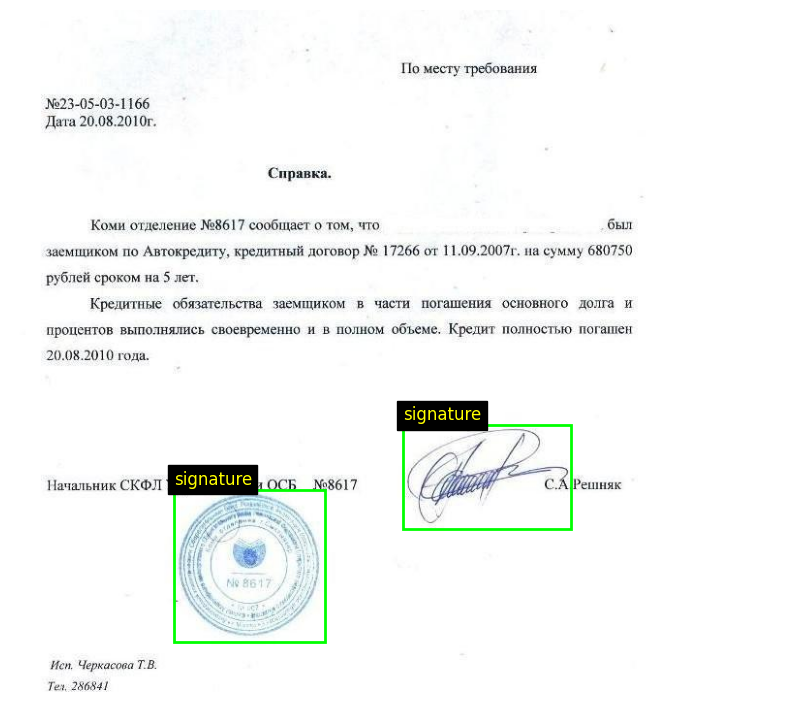

In [9]:
import yaml
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

yaml_path = r"D:\studying\university\armeta_hackathon\dataset_final\data.yaml"
dataset_root = os.path.dirname(yaml_path)

with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)

# Build full path to train/images
train_dir = os.path.join(dataset_root, data["train"].replace("/", os.sep))

img_files = [f for f in os.listdir(train_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
img_name = random.choice(img_files)
img_path = os.path.join(train_dir, img_name)

# Label file path
label_path = img_path.replace("images", "labels").rsplit(".", 1)[0] + ".txt"

img = Image.open(img_path)
w, h = img.size

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)
ax.set_axis_off()

if os.path.exists(label_path):
    with open(label_path, "r") as f:
        for line in f:
            cls, xc, yc, bw, bh = map(float, line.strip().split())
            xc *= w
            yc *= h
            bw *= w
            bh *= h
            x_min = xc - bw / 2
            y_min = yc - bh / 2
            rect = patches.Rectangle((x_min, y_min), bw, bh,
                                     linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min - 5,
                    data["names"][int(cls)],
                    color="yellow", fontsize=12, backgroundcolor="black")

plt.show()


# Model Training — YOLO for Signature and Seal Detection

This section describes the training pipeline used to develop the detection model for the hackathon.

## Training Objective
Train a YOLO-based detector capable of accurately identifying:
- signatures  
- stamps/seals  

across noisy, low-contrast, and diverse construction document scans.

## Compute Setup
Training executed on:
- NVIDIA GPUs (4090 / 5000 Ada / RTX series)
- PyTorch 2.5+
- Ultralytics YOLO 8.3+

## Model Choice
We selected **YOLOv8-Large** (`yolov8l.pt`) due to:
- high accuracy on small objects  
- stable detection of faint signatures  
- strong generalization across document types  

## Training Hyperparameters
Document-safe augmentations were applied:
- rotation: `degrees=5`
- scaling: `scale=0.10`
- limited mosaic/mixup
- light color jitter (`hsv_s`, `hsv_v`)

These help maintain the natural appearance of signatures and seals while improving robustness.

## Optimization Strategy
- Optimizer: **AdamW**  
- Learning rate schedule: **cosine decay**  
- Early stopping: `patience=20`  

## Evaluation Metrics
During training we monitor:
- precision  
- recall  
- mAP50 and mAP50–95  
- per-class performance (signature, seal)

These metrics guide model selection and validation.

The following cell initiates the full training process.


In [1]:
from ultralytics import YOLO
import torch

yaml_path = r"C:\Users\w2\OneDrive\Desktop\Amir\armeta_hackathon\dataset_final\data.yaml"
print("Using GPU:", torch.cuda.get_device_name(0))
model = YOLO("yolov8l.pt")
model.train(
    data=yaml_path,
    epochs=50,
    imgsz=1024,
    batch=16,
    device=0,
    workers=8,
    patience=20,

    # Optimizer
    optimizer="AdamW",
    lr0=0.001,
    cos_lr=True,

    # Safe augmentations for document scans
    degrees=5,
    scale=0.10,
    shear=0.0,
    perspective=0.0,
    mixup=0.0,
    mosaic=0.0,

    hsv_h=0.0,
    hsv_s=0.1,
    hsv_v=0.2,

    verbose=True
)


ERROR Error writing to C:\Users\w2\AppData\Roaming\Ultralytics\settings.json: [Errno 13] Permission denied: 'C:\\Users\\w2\\AppData\\Roaming\\Ultralytics\\settings.json'
WARNING Ultralytics settings reset to default values. This may be due to a possible problem with your settings or a recent ultralytics package update. 
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\w2\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
ERROR Error writing to C:\Users\w2\AppData\Roaming\Ultralytics\settings.json: [Errno 13] Permission denied: 'C:\\Users\\w2\\AppData\\Roaming\\Ultralytics\\settings.json'
ERROR Error writing to C:\Users\w2\AppData\Roaming\Ultralytics\settings.json: [Errno 13] Permission denied: 'C:\\Users\\w2\\AppData\\Roaming\\Ultralytics\\settings.json'
ERROR Error writing to C:\Users\w2\AppData\Roaming\Ultralytics

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002158C152A10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

## 📊 Training Results & Best Model Selection

After training completes, YOLO reports:
- detection precision & recall,
- mAP50 and mAP50–95,
- per-class statistics,
- training/inference speed,
- saved checkpoints inside `runs/detect/train_final/`.

We select the **best.pt** model from the training directory for the inference pipeline used in the hackathon submission.

This checkpoint achieves strong performance on both signature and seal detection.

---


